In [1]:
import torch
from torch import Tensor
import torch.nn.functional as F
import transformer_lens
from transformer_lens import HookedTransformer, HookedTransformerConfig
from einops import einsum

In [2]:
from jaxtyping import Int, Float
from typing import List, Tuple, Optional, Literal
import numpy as np
from transformer_lens import utils
import matplotlib.pyplot as plt

In [3]:
model = HookedTransformer.from_pretrained("gpt2-small")

Loaded pretrained model gpt2-small into HookedTransformer


In [4]:
text = "James"
target_idx = model.to_single_token(' Cameron')
# model.to_str_tokens(text)
# model.to_str_tokens(model(text)[0, -1].argsort(dim=-1)[-100:])

In [5]:
target_idx

10821

In [6]:
logits, cache = model.run_with_cache(text, remove_batch_dim=True)

In [7]:
def get_layer_attributions(
    model: HookedTransformer,
    typ: Literal["attn", "mlp"],
    cache: dict[str, Tensor],
    target_idx: Int
) -> Tensor:
    
    target_U = model.W_U[:, target_idx]

    attrib_list = []
    for layer in range(model.cfg.n_layers):
        block_out = cache[f"blocks.{layer}.hook_{typ}_out"][-1]
        attrib_list.append(block_out @ target_U)

    return torch.tensor(attrib_list)

In [8]:
def decompose_head_attribs(
    model: HookedTransformer,
    cache: dict[str, Tensor],
    target_idx: Int,
) -> Float[Tensor, "n_layers n_heads"]:
    
    ret_attribs = torch.zeros(12, 12)
    for layer in range(model.cfg.n_layers):    
        decomp_head_out = einsum(
                            cache[f"blocks.{layer}.attn.hook_z"],
                            model.blocks[layer].attn.W_O,
                            "seq n_heads d_head, n_heads d_head d_model -> seq n_heads d_model"
                        )
    
        dec_head_attribs = einsum(
                            decomp_head_out[-1],
                            model.W_U[:, target_idx],
                            "n_heads d_model, d_model -> n_heads",
                        )
        ret_attribs[layer] = dec_head_attribs

    return ret_attribs

In [14]:
cache["blocks.0.mlp.hook_pre"].size(), cache["blocks.0.mlp.hook_post"].size(), cache["blocks.0.hook_mlp_out"].size()

(torch.Size([2, 3072]), torch.Size([2, 3072]), torch.Size([2, 768]))

In [16]:
dcm_head_attribs = decompose_head_attribs(model, cache, target_idx)
dcm_head_attribs.sum(dim=-1)
dcm_head_attribs.size()    # n_layers, n_heads

torch.Size([12, 12])

In [11]:
attn_layer_attribs = get_layer_attributions(model, "attn", cache, target_idx)
mlp_layer_attribs = get_layer_attributions(model, "mlp", cache, target_idx)
attn_layer_attribs, mlp_layer_attribs

(tensor([ 8.0220, -0.1912,  0.1902,  0.2457, -0.0389, -0.1783,  0.5704, -0.1336,
         -0.3356,  1.2370,  1.8675,  4.8272]),
 tensor([16.1212,  8.5566,  3.7361,  0.3699,  3.5614,  7.6665,  9.8978, 11.1538,
          7.8097,  6.9012,  6.5303, 27.2531]))

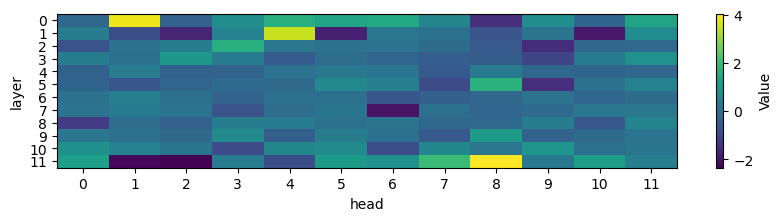

In [19]:
detached_dcm_head_attribs = dcm_head_attribs.detach().cpu().numpy()
detached_mlp_layer_attribs = mlp_layer_attribs.detach().cpu().numpy()

plt.figure(figsize=(10, 2), dpi=100)
plt.imshow(detached_dcm_head_attribs, cmap="viridis", aspect="auto")
plt.xticks(range(12))
plt.xlabel("head")
plt.yticks(range(12))
plt.ylabel("layer")
plt.colorbar(label='Value')
plt.show()

In [13]:
# 1.find the absolute contributions - removing mean contribution of layers